## Google Drive login 

In [ ]:
"""!pip install --upgrade gupload

from pydrive.auth import GoogleAuth
from google.colab import auth

# Authenticate and create the PyDrive client.
auth.authenticate_user()"""

     |████████████████████████████████| 61kB 5.5MB/s 
     |████████████████████████████████| 81kB 8.2MB/s 
ERROR: earthengine-api 0.1.266 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-python-client 1.7.10 which is incompatible.
  Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-api-python-client-1.12.8:
      Successfully uninstalled google-api-python-client-1.12.8
  Found existing installation: click 7.1.2
    Uninstalling click-7.1.2:
      Successfully uninstalled click-7.1.2


# Classification task

## Imports

In [ ]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import KFold

np.random.seed(22)
torch.manual_seed(22)

## Dataset

Download the dataset:

In [ ]:
train_dataset = torchvision.datasets.MNIST('classifier_data', train=True, download=True)
test_dataset  = torchvision.datasets.MNIST('classifier_data', train=False, download=True)


Extracting classifier_data/MNIST/raw/train-images-idx3-ubyte.gz to classifier_data/MNIST/raw




Extracting classifier_data/MNIST/raw/train-labels-idx1-ubyte.gz to classifier_data/MNIST/raw




Extracting classifier_data/MNIST/raw/t10k-images-idx3-ubyte.gz to classifier_data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting classifier_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to classifier_data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Select device

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Training device: {device}")

Training device: cpu


## Model definition

### Early stopping class

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### Neural Network class

In [ ]:
class Net(nn.Module):
    def __init__(self, dropout=0):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2)
        flatten_dim = 32*8*8 # channels*width*height
        self.fc1 = nn.Linear(flatten_dim, 128)
        self.fc2 = nn.Linear(128, 10)
        self.drop = nn.Dropout(dropout)
        self.mpool = nn.MaxPool2d(2, 2) 

    def forward(self, x, additional_out=-1):
        x = F.relu(self.conv1(x))
        if additional_out == 1:
            return x
        x = self.mpool(x)
        x = F.relu(self.conv2(x))
        if additional_out == 2:
            return x
        x = self.mpool(x)
        x = x.reshape(x.size(0), -1)
        x = self.drop(x)
        x = F.relu(self.fc1(x))
        x = self.drop(x)
        x = self.fc2(x)
        #x = F.softmax(x, dim=-1) 
        return x 

    def train_net(self, train_loader, val_loader, loss_function, optimizer, num_epochs, device):
        train_loss_log = []
        val_loss_log = []
        # initialize the early_stopping object
        early_stopping = EarlyStopping(patience=10, verbose=False)
        for epoch_num in range(num_epochs):
            print('------------------------------------------------------------')
            print(f'EPOCH {epoch_num}')
            # ....................... TRAIN .......................
            train_loss = []
            self.train() # Training mode (e.g. enable dropout)
            for sample_batched in train_loader:
                # Move data to device
                x = sample_batched[0].to(device)
                label = sample_batched[1].to(device)
                # Forward pass
                out = self.forward(x)
                # Compute loss
                loss = loss_function(out, label)
                # Backpropagation
                self.zero_grad()
                loss.backward()
                # Update the weights
                optimizer.step()
                # Save train loss for this batch
                loss_batch = loss.detach().cpu().numpy()
                train_loss.append(loss_batch)
            # Save average train loss
            train_loss = np.mean(train_loss)
            print(f"Average train loss: {train_loss}")
            train_loss_log.append(train_loss)
            # .................... VALIDATION .....................
            val_loss= []
            self.eval() # Evaluation mode (e.g. disable dropout)
            with torch.no_grad(): # Disable gradient tracking
                for sample_batched in val_loader:
                    # Move data to device
                    x = sample_batched[0].to(device)
                    label = sample_batched[1].to(device)
                    # Forward pass
                    out = self.forward(x)
                    # Compute loss
                    loss = loss_function(out, label)
                    # Save val loss for this batch
                    loss_batch = loss.detach().cpu().numpy()
                    val_loss.append(loss_batch)
            # Save average validation loss
            val_loss = np.mean(val_loss)
            print(f"Average validation loss: {np.mean(val_loss)}")
            val_loss_log.append(val_loss)
            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            early_stopping(val_loss, self)
            if early_stopping.early_stop:
                print("Early stopping")
                break
        return train_loss_log, val_loss_log

    def predict(self, test_loader, loss_function, device):
        inputs = []
        outputs = [] 
        labels = []
        self.eval()
        with torch.no_grad():
            for sample_batched in test_loader:
                x = sample_batched[0].to(device)
                label = sample_batched[1].to(device) 
                out = self.forward(x) 
                inputs.append(x)
                outputs.append(out)
                labels.append(label) 
        # concatenate the input, outputs and label in a single tensor
        inputs = torch.cat(inputs)
        outputs = torch.cat(outputs)
        labels = torch.cat(labels)
        test_loss = loss_function(outputs, labels) 
        return inputs, outputs, labels, test_loss

    def save(self, path):
        # The state dictionary includes all the parameters of the network
        net_state_dict = self.state_dict()
        # Save the state dict to a file
        torch.save(net_state_dict, path)

    def load(self, path):
        # Load the state dict previously saved
        net_state_dict = torch.load(path)
        # Update the network parameters
        self.load_state_dict(net_state_dict)

In [ ]:
def plot_loss(train_loss_log, val_loss_log):
    plt.figure(figsize=(12, 7))
    plt.plot(train_loss_log, label='Train')
    plt.plot(val_loss_log, label='Validation')
    plt.xlabel('Epoch', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    plt.tick_params(axis='both', labelsize=14)
    plt.legend(fontsize=18)
    plt.grid(linestyle='--')
    plt.savefig('loss.pdf', bbox_inches='tight')
    plt.show()

## Define possible transformations

In [ ]:
add_noise = torchvision.transforms.GaussianBlur(kernel_size=3)
rotation = torchvision.transforms.RandomRotation(30)

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

composed_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    transforms.RandomChoice([AddGaussianNoise(0., 1.), add_noise, rotation])
])

In [ ]:
train_dataset = torchvision.datasets.MNIST('classifier_data', 
                                           transform=composed_transform, 
                                           train=True, 
                                           download=True)

## Cross validation

In [ ]:
def CrossValidation(config, dataset, device, k_fold=4, n_runs=3):
    """Cross validation function.
    Args:
        config (dict): hyperparameters dictionary
        dataset (Dataset): Dataset containing the data
        k_fold (int): number of folds for cross-validation 
    """
    par_log = []
    train_loss_log = []
    val_loss_log = []
    for i in range(n_runs):
        total_size = len(dataset)
        fraction = 1/k_fold
        seg = int(total_size * fraction)
        # tr:train, val:validation; r:right, l:left;  eg: trrr: right index of right side train subset 
        # index: [trll,trlr],[vall,valr],[trrl,trrr]
        for i in range(k_fold):
            trll = 0
            trlr = i * seg
            vall = trlr
            valr = i * seg + seg
            trrl = valr
            trrr = total_size
            #print("train indices: [%d,%d),[%d,%d), test indices: [%d,%d)" 
            #      % (trll,trlr,trrl,trrr,vall,valr))
            train_left_indices = list(range(trll, trlr))
            train_right_indices = list(range(trrl, trrr))
            train_indices = train_left_indices + train_right_indices
            val_indices = list(range(vall, valr))
            train_set = torch.utils.data.dataset.Subset(dataset, train_indices)
            val_set = torch.utils.data.dataset.Subset(dataset, val_indices)  
            train_loader = torch.utils.data.DataLoader(train_set, batch_size=10,
                                            shuffle=True, num_workers=2)
            val_loader = torch.utils.data.DataLoader(val_set, batch_size=10,
                                            shuffle=False, num_workers=2)
            # Take a random sample of parameters
            par_sample = {}
            for k in config.keys():
                par_sample[k] = np.random.choice(config[k])
            par_log.append(par_sample)
            # Initalize the model 
            pDrop = par_sample['Dropout']
            model = Net(pDrop).to(device)
            if par_sample['Optimizer'] == 'Adam':
                opt = optim.Adam(model.parameters(), lr=par_sample['Learning_rate'], 
                                weight_decay=par_sample['Regularization'])
            if par_sample['Optimizer'] == 'SGD':
                opt = optim.SGD(model.parameters(), lr=par_sample['Learning_rate'],
                                momentum=0.9, weight_decay=par_sample['Regularization'])
            loss = nn.CrossEntropyLoss()
            train_loss, val_loss = model.train_net(train_loader, 
                                                   val_loader, 
                                                   loss, 
                                                   opt, 
                                                   par_sample['Epochs'], 
                                                   device)
            train_loss_log.append(train_loss)
            val_loss_log.append(val_loss)
    return par_log, train_loss_log, val_loss_log

In [ ]:
"""
config = {
    'Epochs': [25, 50],
    'Optimizer': ['SGD', 'Adam'],
    'Regularization': [1e-2, 1e-3, 1e-4, 1e-5],
    'Learning_rate': [0.01, 0.001, 0.0001],
    'Dropout': [0.1, 0.2, 0.3]
}
"""

"\nconfig = {\n    'Epochs': [25, 50],\n    'Optimizer': ['SGD', 'Adam'],\n    'Regularization': [1e-2, 1e-3, 1e-4, 1e-5],\n    'Learning_rate': [0.01, 0.001, 0.0001],\n    'Dropout': [0.1, 0.2, 0.3]\n}\n"

In [ ]:
"""
par_kfold, train_loss_kfold, val_loss_kfold = CrossValidation(config, 
                                                              train_dataset, 
                                                              device, 
                                                              k_fold=4, 
                                                              n_runs=2)
"""

'\npar_kfold, train_loss_kfold, val_loss_kfold = CrossValidation(config, \n                                                              train_dataset, \n                                                              device, \n                                                              k_fold=4, \n                                                              n_runs=2)\n'

## Random grid search

In [ ]:
def RandomGridSearch(train_loader, val_loader, config, device, n_runs=3):
    par_log = []
    train_loss_log = []
    val_loss_log = []
    for i in range(n_runs):
        # Take a random sample of parameters
        par_sample = {}
        for k in config.keys():
            par_sample[k] = np.random.choice(config[k])
        par_log.append(par_sample)
        # Initalize the model 
        pDrop = par_sample['Dropout']
        model = Net(pDrop).to(device)
        if par_sample['Optimizer'] == 'Adam':
            opt = optim.Adam(model.parameters(), lr=par_sample['Learning_rate'], 
                            weight_decay=par_sample['Regularization'])
        if par_sample['Optimizer'] == 'SGD':
            opt = optim.SGD(model.parameters(), lr=par_sample['Learning_rate'],
                            momentum=0.9, weight_decay=par_sample['Regularization'])
        loss = nn.CrossEntropyLoss()
        train_loss, val_loss = model.train_net(train_loader, 
                                               val_loader, 
                                               loss, 
                                               opt, 
                                               par_sample['Epochs'], 
                                               device)
        train_loss_log.append(train_loss)
        val_loss_log.append(val_loss)
    return par_log, train_loss_log, val_loss_log

In [ ]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

In [ ]:
config = {
    'Epochs': [25, 50], 
    'Optimizer': ['SGD', 'Adam'],
    'Regularization': [1e-2, 1e-3, 1e-4, 1e-5],
    'Learning_rate': [0.01, 0.001, 0.0001],
    'Dropout': [0.1, 0.2, 0.3]
}

In [ ]:
par_rgs, train_loss_rgs, val_loss_rgs = RandomGridSearch(train_loader, 
                                                         val_loader, 
                                                         config, 
                                                         device, 
                                                         n_runs=10) 

------------------------------------------------------------
EPOCH 0
Average train loss: 2.2515640258789062
Average validation loss: 2.1519763469696045
------------------------------------------------------------
EPOCH 1
Average train loss: 1.9371800422668457
Average validation loss: 1.50487220287323
------------------------------------------------------------
EPOCH 2
Average train loss: 1.2660531997680664
Average validation loss: 0.8605852127075195
------------------------------------------------------------
EPOCH 3
Average train loss: 0.9306865334510803
Average validation loss: 0.6472576260566711
------------------------------------------------------------
EPOCH 4
Average train loss: 0.7885885834693909
Average validation loss: 0.5510516166687012
------------------------------------------------------------
EPOCH 5
Average train loss: 0.6985400319099426
Average validation loss: 0.5005918145179749
------------------------------------------------------------
EPOCH 6
Average train loss: 0

## Train the model with best parameters

In [ ]:
#val_final_losses = [v[-1] for v in val_loss_kfold]
#best_par = par_kfold[np.argmin(val_final_losses)]
val_final_losses = [v[-1] for v in val_loss_rgs]
best_par = par_rgs[np.argmin(val_final_losses)]
best_par

{'Dropout': 0.2,
 'Epochs': 50,
 'Learning_rate': 0.0001,
 'Optimizer': 'Adam',
 'Regularization': 1e-05}

In [ ]:
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)

In [ ]:
with open('class_best_par.txt', 'w') as f:
    print(best_par, file=f)
!gupload --to '1DIDzlTJFk4Ks4rWgCfvjq_Pm6kL6ADDX' class_best_par.txt

Uploading file: class_best_par.txt


In [ ]:
pDrop = best_par['Dropout']
model = Net(pDrop).to(device)
if best_par['Optimizer'] == 'Adam':
    opt = optim.Adam(model.parameters(), 
                    lr=best_par['Learning_rate'], 
                    weight_decay=best_par['Regularization'])
elif best_par['Optimizer'] == 'SGD':
    opt = optim.SGD(model.parameters(), lr=par_sample['Learning_rate'],
                    momentum=0.9, weight_decay=par_sample['Regularization'])
loss = nn.CrossEntropyLoss()
train_loss, val_loss = model.train_net(train_loader, 
                                       val_loader, 
                                       loss, 
                                       opt, 
                                       best_par['Epochs'], 
                                       device)

------------------------------------------------------------
EPOCH 0
Average train loss: 0.7599362134933472
Average validation loss: 0.32213348150253296
------------------------------------------------------------
EPOCH 1
Average train loss: 0.2972778379917145
Average validation loss: 0.19804821908473969
------------------------------------------------------------
EPOCH 2
Average train loss: 0.21514740586280823
Average validation loss: 0.14687736332416534
------------------------------------------------------------
EPOCH 3
Average train loss: 0.17385050654411316
Average validation loss: 0.12341813743114471
------------------------------------------------------------
EPOCH 4
Average train loss: 0.1483055204153061
Average validation loss: 0.10724546015262604
------------------------------------------------------------
EPOCH 5
Average train loss: 0.13433681428432465
Average validation loss: 0.09986526519060135
------------------------------------------------------------
EPOCH 6
Average tr

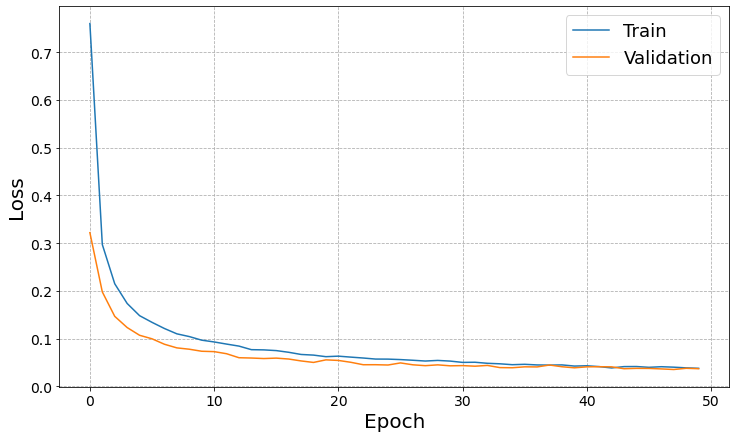

In [ ]:
plot_loss(train_loss, val_loss)

### Save the network and the optimizer state

In [ ]:
# Save the net
model.save('net_class_parameters.torch')

In [ ]:
# Save the optimizer state
torch.save(opt.state_dict(), 'optimizer_class_state.torch')

## Model test

In [ ]:
test_dataset = torchvision.datasets.MNIST('classifier_data', 
                                          transform=transforms.Compose([
                                                transforms.ToTensor(),
                                                transforms.Normalize((0.1307,), (0.3081,))]),
                                          train=False, 
                                          download=True)

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
inputs, outputs, labels, test_loss = model.predict(test_loader, loss, device)

In [ ]:
outputs = outputs.detach().cpu().numpy()
labels = labels.detach().cpu().numpy()

In [ ]:
predicted_labels = [outputs[i].argmax() for i in range(len(outputs))]
diffs = np.array([predicted_labels[i]-labels[i] for i in range(len(outputs))])
wrong = np.count_nonzero(diffs) 
test_accuracy = 1 - wrong/len(outputs)
print("Test accuracy: ", test_accuracy)

Test accuracy:  0.9927


## Network analysis

### Load the model

In [ ]:
#best_par = {
#    'Dropout': 0.2,
#    'Epochs': 50,
#    'Learning_rate': 0.0001,
#    'Optimizer': 'Adam',
#    'Regularization': 1e-5
#}

model = Net(best_par['Dropout']).to(device)

model.load('net_class_parameters.torch')

### Weights histograms

In [ ]:
# First convolutional layer
c1_w = model.conv1.weight.data.cpu().numpy() 
c1_b = model.conv1.bias.data.cpu().numpy() 

# Second convolutional layer
c2_w = model.conv2.weight.data.cpu().numpy()
c2_b = model.conv2.bias.data.cpu().numpy() 

# First hidden layer
h1_w = model.fc1.weight.data.cpu().numpy() 
h1_b = model.fc1.bias.data.cpu().numpy() 

# Second hidden layer
h2_w = model.fc2.weight.data.cpu().numpy()
h2_b = model.fc2.bias.data.cpu().numpy() 

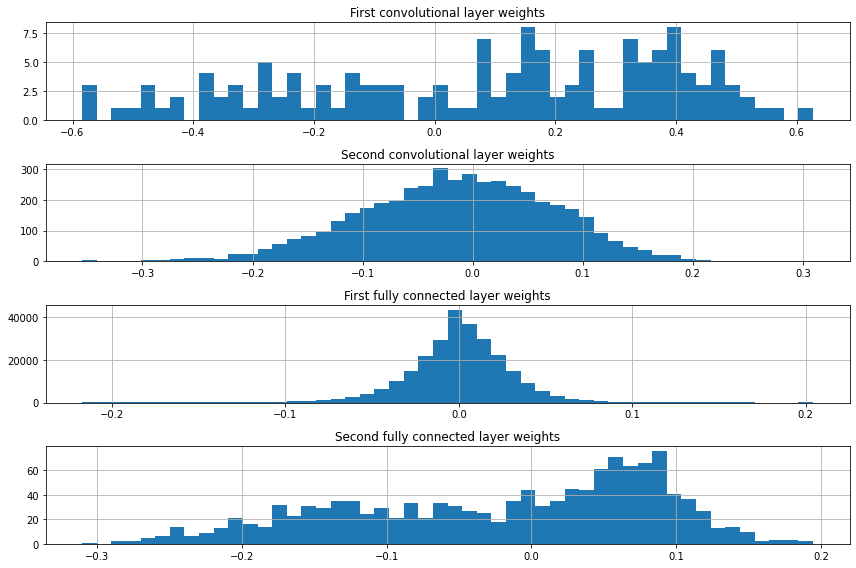

In [ ]:
# Weights histogram
fig, axs = plt.subplots(4, 1, figsize=(12,8))
axs[0].hist(c1_w.flatten(), 50)
axs[0].set_title('First convolutional layer weights')
axs[1].hist(c2_w.flatten(), 50)
axs[1].set_title('Second convolutional layer weights')
axs[2].hist(h1_w.flatten(), 50)
axs[2].set_title('First fully connected layer weights')
axs[3].hist(h2_w.flatten(), 50)
axs[3].set_title('Second fully connected layer weights')
[ax.grid() for ax in axs]
plt.tight_layout()
plt.savefig('class_weights_histo.pdf', bbox_inches='tight')
plt.show()

### Activations

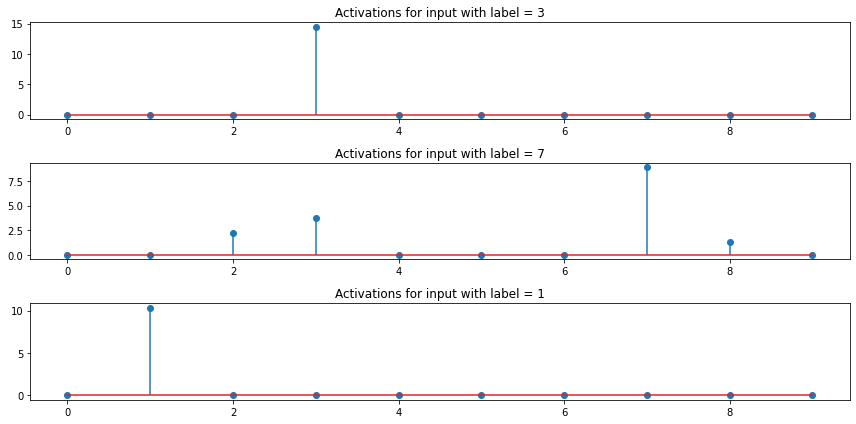

In [ ]:
def get_activation(layer, input, output):
    global activation
    activation = torch.relu(output) 

### Register hook  
hook_handle = model.fc2.register_forward_hook(get_activation)

### Analyze activations
model = model.to(device)
model.eval()
tloader = DataLoader(train_set, batch_size=1, shuffle=True)
with torch.no_grad():
    for sample_batched in tloader:
        x1 = sample_batched[0].to(device)
        label1 = sample_batched[1].to(device)
        break
    y1 = model(x1)
    z1 = activation
    for sample_batched in tloader:
        x2 = sample_batched[0].to(device)
        label2 = sample_batched[1].to(device)
        break
    y2 = model(x2)
    z2 = activation
    for sample_batched in tloader:
        x3 = sample_batched[0].to(device)
        label3 = sample_batched[1].to(device)
        break
    y3 = model(x3)
    z3 = activation

### Remove hook
hook_handle.remove()

### Plot activations
fig, axs = plt.subplots(3, 1, figsize=(12,8))
axs[0].stem(z1.cpu().numpy()[0], use_line_collection=True)
axs[0].set_title('Activations for input with label = %d' % label1.cpu().numpy())
axs[1].stem(z2.cpu().numpy()[0], use_line_collection=True)
axs[1].set_title('Activations for input with label = %d' % label2.cpu().numpy())
axs[2].stem(z3.cpu().numpy()[0], use_line_collection=True)
axs[2].set_title('Activations for input with label = %d' % label3.cpu().numpy())
plt.tight_layout()
plt.savefig('class_activations.pdf', bbox_inches='tight')
plt.show()

### Filters

In [ ]:
image_sample = DataLoader(test_dataset, batch_size=1, shuffle=False) 
with torch.no_grad(): 
    for sample_batched in (image_sample):
        x_batch = sample_batched[0].to(device)
        out1 = model.forward(x_batch, additional_out=1)
        out1 = out1.cpu().numpy()
        break

[]

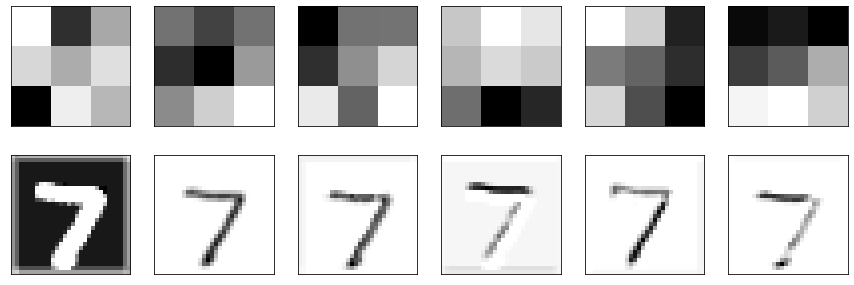

In [ ]:
fig, axs = plt.subplots(2, 6, figsize=(15,5))
axs = axs.flatten()
for i in range(6):
    axs[i].imshow(c1_w[i, 0, :, :], cmap='Greys')
    axs[i].set_yticks([])
    axs[i].set_xticks([])
for i in range(6):
    axs[i+6].imshow(out1[0, i, :, :], cmap='Greys')
    axs[i+6].set_yticks([])
    axs[i+6].set_xticks([])

plt.savefig('filters_features_c1.pdf', bbox_inches='tight')
plt.plot()

In [ ]:
 with torch.no_grad(): 
    for sample_batched in (image_sample):
        x_batch = sample_batched[0].to(device)
        out2 = model.forward(x_batch, additional_out=2)
        out2 = out2.cpu().numpy()
        break

[]

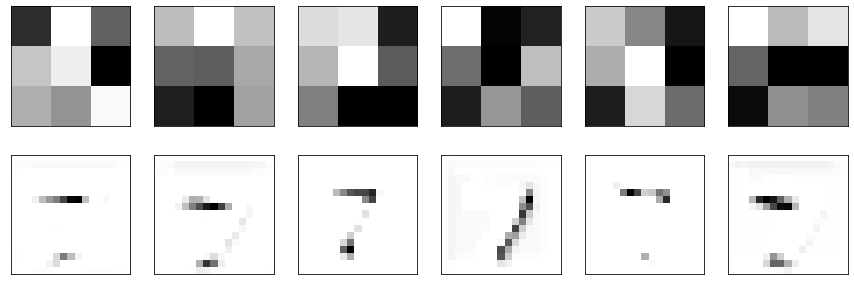

In [ ]:
fig, axs = plt.subplots(2, 6, figsize=(15,5))
axs = axs.flatten()
for i in range(6):
    axs[i].imshow(c2_w[i, 0, :, :], cmap='Greys')
    axs[i].set_yticks([])
    axs[i].set_xticks([])
for i in range(6):
    axs[i+6].imshow(out2[0, i, :, :], cmap='Greys')
    axs[i+6].set_yticks([])
    axs[i+6].set_xticks([])

plt.savefig('filters_features_c2.pdf', bbox_inches='tight')
plt.plot()

## Save outputs in Google Drive

In [ ]:
#!mkdir outs1
#!mv filters_features_c1.pdf filters_features_c2.pdf outs1
#!gupload --to '1DIDzlTJFk4Ks4rWgCfvjq_Pm6kL6ADDX' outs1/*

In [ ]:
#!mkdir outs2
#!mv checkpoint.pt loss.pdf net_class_parameters.torch optimizer_class_state.torch class_activations.pdf class_weights_histo.pdf filters_features_c1.pdf filters_features_c2.pdf outs2
#!gupload --to 'INSERT ADDRESS' outs2/*

In [ ]:
#with open('accuracy.txt', 'w') as f:
#    print('Test accuracy:  0.9927', file=f) 
#!gupload --to '1DIDzlTJFk4Ks4rWgCfvjq_Pm6kL6ADDX' accuracy.txt